In [59]:
import pandas as pd
import os
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Flatten
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [60]:
root = os.getcwd()

In [61]:
# Directory paths for each group of data
train_dirpath_A = os.path.join(root, "data", "A")
train_dirpath_B = os.path.join(root, "data", "B")
train_dirpath_C = os.path.join(root, "data", "C")

# pv_measurement for all training and validation rows
a_targets = pd.read_parquet(os.path.join(train_dirpath_A, 'train_targets.parquet'))
b_targets = pd.read_parquet(os.path.join(train_dirpath_B, 'train_targets.parquet'))
c_targets = pd.read_parquet(os.path.join(train_dirpath_C, 'train_targets.parquet'))

# training data
X_train_observed_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_observed.parquet'))
X_train_observed_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_observed.parquet'))
X_train_observed_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_observed.parquet'))

# validation data
X_train_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_estimated.parquet'))
X_train_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_estimated.parquet'))
X_train_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_estimated.parquet'))

# test data
X_test_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_test_estimated.parquet'))
X_test_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_test_estimated.parquet'))
X_test_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_test_estimated.parquet'))

### Autogluon

In [62]:
X_train_estimated_a['is_predicted'] = 1
X_train_observed_a['is_predicted'] = 0

X_train_estimated_b['is_predicted'] = 1
X_train_observed_b['is_predicted'] = 0

X_train_estimated_c['is_predicted'] = 1
X_train_observed_c['is_predicted'] = 0

X_test_estimated_a['is_predicted'] = 1
X_test_estimated_b['is_predicted'] = 1
X_test_estimated_c['is_predicted'] = 1

X_test_estimated_a.drop(columns=['date_calc'], inplace=True) 
X_test_estimated_b.drop(columns=['date_calc'], inplace=True) 
X_test_estimated_c.drop(columns=['date_calc'], inplace=True) 

In [63]:
def move_rows(training, validation):
    num_rows_to_remove = int(0.5 * len(validation))

    # Remove the first num_rows_to_remove rows from X_train_estimated_a and add them to X_train_observed_a
    removed_data = validation.iloc[:num_rows_to_remove]
    validation = validation.iloc[num_rows_to_remove:]
    training = pd.concat([training, removed_data], ignore_index=True)

    validation.drop(columns=['date_calc'], inplace=True)  
    training.drop(columns=['date_calc'], inplace=True)  

    return training, validation

In [64]:
X_train_observed_a, X_train_estimated_a = move_rows(X_train_observed_a, X_train_estimated_a)
X_train_observed_b, X_train_estimated_b = move_rows(X_train_observed_b, X_train_estimated_b)
X_train_observed_c, X_train_estimated_c = move_rows(X_train_observed_c, X_train_estimated_c)

/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_59333/5949636.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.drop(columns=['date_calc'], inplace=True)
/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_59333/5949636.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation.drop(columns=['date_calc'], inplace=True)
/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_59333/5949636.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [65]:
def aggregate_data(df):
    df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')

    df.set_index('hourly_timestamp', inplace=True)

    aggregations = {col: 'mean' for col in df.columns if col != 'date_forecast'}
    aggregations['date_forecast'] = 'first'

    df = df.groupby('hourly_timestamp').agg(aggregations).reset_index()

    df.drop(columns=['hourly_timestamp'], inplace=True)
    df['date_forecast'] = df['date_forecast'].dt.floor('H')
    
    return df

In [66]:
def mark_consecutive_identical(series, threshold=23):
    """Mark sequences of threshold or more identical consecutive values with NaN"""
    # Start by finding all the points where the series changes
    diff = series.diff().ne(0)
    # Count consecutive occurrences
    count = (~diff).groupby(diff.cumsum()).cumsum()
    # Mark sequences with threshold or more occurrences with NaN
    series[count >= threshold] = np.nan
    return series


# Remove the bad observations (noise) in pv_measurement
def drop_noise_in_pv_measurement(merged_data):

    # Mark the appropriate rows in 'pv_measurement' with NaN
    merged_data['pv_measurement'] = mark_consecutive_identical(merged_data['pv_measurement'])

    # Drop rows where 'pv_measurement' is NaN
    merged_data.dropna(subset=['pv_measurement'], inplace=True)

    return merged_data

In [67]:
def process(data, targets, visualize=False):
    aggregated_data = aggregate_data(data.copy())
    
    merged_data = aggregated_data.merge(targets[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
    merged_data = drop_noise_in_pv_measurement(merged_data)
    merged_data.dropna(subset=['pv_measurement'], inplace=True)

    y = merged_data["pv_measurement"]
    X = merged_data.drop(columns=['pv_measurement', 'date_forecast', 'time'])
    return X, y

In [68]:
X_train_A, y_train_A = process(X_train_observed_a, a_targets, visualize=True)
X_val_A, y_val_A = process(X_train_estimated_a, a_targets)

X_test_A = aggregate_data(X_test_estimated_a.copy())

X_train_B, y_train_B = process(X_train_observed_b, b_targets, visualize=True)
X_val_B, y_val_B = process(X_train_estimated_b, b_targets)

X_test_B = aggregate_data(X_test_estimated_b.copy())

X_train_C, y_train_C = process(X_train_observed_c, c_targets, visualize=True)
X_val_C, y_val_C = process(X_train_estimated_c, c_targets)

X_test_C = aggregate_data(X_test_estimated_c.copy())

/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_59333/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan
/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_59333/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan
/var/folders/18/r2ql_22j6qz613qdzqhrv5bc0000gn/T/ipykernel_59333/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [69]:
# Clean feature names 
def clean_feature_names(df_list):
    for df in df_list:
        df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

# Apply the cleaning function to your dataframes
lista = [X_train_A, X_val_A, X_test_A, X_train_B, X_val_B, X_test_B, X_train_C, X_val_C, X_test_C]
clean_feature_names(lista)

In [70]:
X_test_A.drop(columns=['date_forecast'], inplace=True) 
X_test_B.drop(columns=['date_forecast'], inplace=True) 
X_test_C.drop(columns=['date_forecast'], inplace=True) 

In [71]:
from autogluon.tabular import TabularPredictor

def train_auto_gluon(X_train, y_train, X_val, y_val):
    # Create and train the AutoGluon model with additional options
    train = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    validation = pd.concat([X_val, y_val.reset_index(drop=True)], axis=1)

    train.dropna(subset=['pv_measurement'], inplace=True)
    validation.dropna(subset=['pv_measurement'], inplace=True)

    # Additional configurations
    additional_configs = {
        "num_stack_levels": 0,
        "num_bag_folds": 8,
        "presets": "best_quality",
        "use_bag_holdout": True,
        "time_limit": 200,  # Set your desired time limit in seconds
        "tuning_data": validation  # Provide your tuning data here
    }
    # Specify the evaluation metric
    predictor = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error', verbosity=2)
    predictor.fit(train_data=train, **additional_configs)

    return predictor


In [72]:
predictor_A = train_auto_gluon(X_train_A, y_train_A, X_val_A, y_val_A)
predictor_B = train_auto_gluon(X_train_B, y_train_B, X_val_B, y_val_B)
predictor_C = train_auto_gluon(X_train_C, y_train_C, X_val_C, y_val_C)

# Making predictions
y_pred_A = predictor_A.predict(X_test_A)
y_pred_B = predictor_B.predict(X_test_B)
y_pred_C = predictor_C.predict(X_test_C)

No path specified. Models will be saved in: "AutogluonModels/ag-20231106_113914"
Presets specified: ['best_quality']
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 200s
AutoGluon will save models to "AutogluonModels/ag-20231106_113914"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:17:35 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T8112
Disk Space Avail:   360.02 GB / 494.38 GB (72.8%)
Train Data Rows:    31844
Train Data Columns: 46
Tunin

[1000]	valid_set's l1: 288.295
[2000]	valid_set's l1: 273.284
[3000]	valid_set's l1: 264.759
[4000]	valid_set's l1: 259.446
[5000]	valid_set's l1: 255.736


	Ran out of time, early stopping on iteration 5825. Best iteration is:
	[5825]	valid_set's l1: 253.551


[1000]	valid_set's l1: 301.161
[2000]	valid_set's l1: 285.599
[3000]	valid_set's l1: 276.577
[4000]	valid_set's l1: 270.34
[5000]	valid_set's l1: 266.359


	Ran out of time, early stopping on iteration 6013. Best iteration is:
	[6013]	valid_set's l1: 262.974


[6000]	valid_set's l1: 263.041
[1000]	valid_set's l1: 296.106
[2000]	valid_set's l1: 282.867
[3000]	valid_set's l1: 275.079
[4000]	valid_set's l1: 270.5
[5000]	valid_set's l1: 267.013
[6000]	valid_set's l1: 264.07


	Ran out of time, early stopping on iteration 6242. Best iteration is:
	[6242]	valid_set's l1: 263.453


[1000]	valid_set's l1: 293.818
[2000]	valid_set's l1: 278.245
[3000]	valid_set's l1: 269.278
[4000]	valid_set's l1: 264.203
[5000]	valid_set's l1: 260.611
[6000]	valid_set's l1: 257.339


	Ran out of time, early stopping on iteration 6453. Best iteration is:
	[6452]	valid_set's l1: 256.085


[1000]	valid_set's l1: 294.51
[2000]	valid_set's l1: 279.152
[3000]	valid_set's l1: 272.266
[4000]	valid_set's l1: 267.151
[5000]	valid_set's l1: 263.834
[6000]	valid_set's l1: 260.953


	Ran out of time, early stopping on iteration 6777. Best iteration is:
	[6776]	valid_set's l1: 259.344


[1000]	valid_set's l1: 299.075
[2000]	valid_set's l1: 282.025
[3000]	valid_set's l1: 274.725
[4000]	valid_set's l1: 269.471
[5000]	valid_set's l1: 265.519
[6000]	valid_set's l1: 262.361
[7000]	valid_set's l1: 260.179


	Ran out of time, early stopping on iteration 7148. Best iteration is:
	[7137]	valid_set's l1: 259.927


[1000]	valid_set's l1: 292.686
[2000]	valid_set's l1: 278.032
[3000]	valid_set's l1: 270.301
[4000]	valid_set's l1: 265.273
[5000]	valid_set's l1: 262.107
[6000]	valid_set's l1: 259.654
[7000]	valid_set's l1: 257.684


	Ran out of time, early stopping on iteration 7793. Best iteration is:
	[7775]	valid_set's l1: 256.247


[1000]	valid_set's l1: 298.489
[2000]	valid_set's l1: 283.827
[3000]	valid_set's l1: 275.613
[4000]	valid_set's l1: 270.316
[5000]	valid_set's l1: 266.367
[6000]	valid_set's l1: 263.623
[7000]	valid_set's l1: 261.087
[8000]	valid_set's l1: 259.174
[9000]	valid_set's l1: 257.52


	Ran out of time, early stopping on iteration 9225. Best iteration is:
	[9225]	valid_set's l1: 257.154
	-728.9614	 = Validation score   (-mean_absolute_error)
	187.49s	 = Training   runtime
	2.41s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4.97s of the 4.97s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 83. Best iteration is:
	[83]	valid_set's l1: 328.498
	Ran out of time, early stopping on iteration 87. Best iteration is:
	[87]	valid_set's l1: 338.797
	Ran out of time, early stopping on iteration 89. Best iteration is:
	[89]	valid_set's l1: 330.376
	Ran out of time, early stopping on iteration 95. Best iteration is:
	[95]	valid_set's l1: 329.1
	Ran out of time, early stopping on iteration 99. Best iteration is:
	[99]	valid_set's l1: 326.051
	Ran out of time, early stopping on iteration 108. Best iteration is:
	[108]	valid_set's l1: 328.093
	

[1000]	valid_set's l1: 87.2716
[2000]	valid_set's l1: 80.8988
[3000]	valid_set's l1: 78.1161
[4000]	valid_set's l1: 76.0636
[5000]	valid_set's l1: 74.4956


	Ran out of time, early stopping on iteration 6060. Best iteration is:
	[6060]	valid_set's l1: 73.4279


[6000]	valid_set's l1: 73.465
[1000]	valid_set's l1: 91.2299
[2000]	valid_set's l1: 84.0945
[3000]	valid_set's l1: 80.4539
[4000]	valid_set's l1: 78.3745
[5000]	valid_set's l1: 76.8619
[6000]	valid_set's l1: 75.7524


	Ran out of time, early stopping on iteration 6163. Best iteration is:
	[6163]	valid_set's l1: 75.5827


[1000]	valid_set's l1: 90.0192
[2000]	valid_set's l1: 83.0921
[3000]	valid_set's l1: 79.851
[4000]	valid_set's l1: 77.5742
[5000]	valid_set's l1: 75.967
[6000]	valid_set's l1: 74.9186


	Ran out of time, early stopping on iteration 6499. Best iteration is:
	[6499]	valid_set's l1: 74.3983


[1000]	valid_set's l1: 88.3703
[2000]	valid_set's l1: 81.8552
[3000]	valid_set's l1: 78.2777
[4000]	valid_set's l1: 75.8465
[5000]	valid_set's l1: 74.2853
[6000]	valid_set's l1: 73.156


	Ran out of time, early stopping on iteration 6645. Best iteration is:
	[6645]	valid_set's l1: 72.5697


[1000]	valid_set's l1: 92.1803
[2000]	valid_set's l1: 86.0784
[3000]	valid_set's l1: 82.8477
[4000]	valid_set's l1: 80.6865
[5000]	valid_set's l1: 79.2667
[6000]	valid_set's l1: 78.1606


	Ran out of time, early stopping on iteration 6988. Best iteration is:
	[6987]	valid_set's l1: 77.4099


[1000]	valid_set's l1: 90.1408
[2000]	valid_set's l1: 84.0605
[3000]	valid_set's l1: 80.9883
[4000]	valid_set's l1: 78.8523
[5000]	valid_set's l1: 77.4261
[6000]	valid_set's l1: 76.362
[7000]	valid_set's l1: 75.5293


	Ran out of time, early stopping on iteration 7348. Best iteration is:
	[7348]	valid_set's l1: 75.2834


[1000]	valid_set's l1: 91.9325
[2000]	valid_set's l1: 85.1723
[3000]	valid_set's l1: 81.5966
[4000]	valid_set's l1: 79.2859
[5000]	valid_set's l1: 77.7355
[6000]	valid_set's l1: 76.537
[7000]	valid_set's l1: 75.7071
[8000]	valid_set's l1: 74.9881


	Ran out of time, early stopping on iteration 8074. Best iteration is:
	[8074]	valid_set's l1: 74.9419


[1000]	valid_set's l1: 91.9285
[2000]	valid_set's l1: 85.4193
[3000]	valid_set's l1: 82.1151
[4000]	valid_set's l1: 79.9991
[5000]	valid_set's l1: 78.5772
[6000]	valid_set's l1: 77.5424
[7000]	valid_set's l1: 76.678
[8000]	valid_set's l1: 75.998
[9000]	valid_set's l1: 75.441


	Ran out of time, early stopping on iteration 9558. Best iteration is:
	[9558]	valid_set's l1: 75.1829
	-145.4867	 = Validation score   (-mean_absolute_error)
	188.41s	 = Training   runtime
	2.1s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4.82s of the 4.82s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 82. Best iteration is:
	[82]	valid_set's l1: 105.147
	Ran out of time, early stopping on iteration 86. Best iteration is:
	[86]	valid_set's l1: 110.484
	Ran out of time, early stopping on iteration 93. Best iteration is:
	[93]	valid_set's l1: 107.746
	Ran out of time, early stopping on iteration 97. Best iteration is:
	[97]	valid_set's l1: 105.394
	Ran out of time, early stopping on iteration 102. Best iteration is:
	[102]	valid_set's l1: 107.824
	Ran out of time, early stopping on iteration 112. Best iteration is:
	[112]	valid_set's l1: 104.59

[1000]	valid_set's l1: 76.6936
[2000]	valid_set's l1: 74.2155
[3000]	valid_set's l1: 72.7787
[4000]	valid_set's l1: 71.9916
[5000]	valid_set's l1: 71.5085
[6000]	valid_set's l1: 71.1825


	Ran out of time, early stopping on iteration 6251. Best iteration is:
	[6248]	valid_set's l1: 71.1195


[1000]	valid_set's l1: 76.9077
[2000]	valid_set's l1: 73.8612
[3000]	valid_set's l1: 72.445
[4000]	valid_set's l1: 71.5277
[5000]	valid_set's l1: 70.9563
[6000]	valid_set's l1: 70.5995


	Ran out of time, early stopping on iteration 6293. Best iteration is:
	[6289]	valid_set's l1: 70.5033


[1000]	valid_set's l1: 77.9821
[2000]	valid_set's l1: 74.9125
[3000]	valid_set's l1: 73.4724
[4000]	valid_set's l1: 72.5532
[5000]	valid_set's l1: 72.0111
[6000]	valid_set's l1: 71.6189


	Ran out of time, early stopping on iteration 6505. Best iteration is:
	[6503]	valid_set's l1: 71.464


[1000]	valid_set's l1: 83.1039
[2000]	valid_set's l1: 80.1775
[3000]	valid_set's l1: 78.7793
[4000]	valid_set's l1: 77.8924
[5000]	valid_set's l1: 77.3464
[6000]	valid_set's l1: 76.9615
[7000]	valid_set's l1: 76.7148


	Ran out of time, early stopping on iteration 7539. Best iteration is:
	[7539]	valid_set's l1: 76.6072


[1000]	valid_set's l1: 79.3617
[2000]	valid_set's l1: 76.4312
[3000]	valid_set's l1: 74.8431
[4000]	valid_set's l1: 73.9297
[5000]	valid_set's l1: 73.2809
[6000]	valid_set's l1: 72.8506
[7000]	valid_set's l1: 72.5711


	Ran out of time, early stopping on iteration 7709. Best iteration is:
	[7706]	valid_set's l1: 72.3935


[1000]	valid_set's l1: 77.1552
[2000]	valid_set's l1: 74.7431
[3000]	valid_set's l1: 73.2759
[4000]	valid_set's l1: 72.4241
[5000]	valid_set's l1: 71.8926
[6000]	valid_set's l1: 71.4802
[7000]	valid_set's l1: 71.175


	Ran out of time, early stopping on iteration 7311. Best iteration is:
	[7309]	valid_set's l1: 71.0963


[1000]	valid_set's l1: 80.5447
[2000]	valid_set's l1: 77.7425
[3000]	valid_set's l1: 76.2002
[4000]	valid_set's l1: 75.2622
[5000]	valid_set's l1: 74.692
[6000]	valid_set's l1: 74.3123
[7000]	valid_set's l1: 74.0464
[8000]	valid_set's l1: 73.8369


	Ran out of time, early stopping on iteration 8614. Best iteration is:
	[8613]	valid_set's l1: 73.7437


[1000]	valid_set's l1: 80.2387
[2000]	valid_set's l1: 77.1298
[3000]	valid_set's l1: 75.5451
[4000]	valid_set's l1: 74.5519
[5000]	valid_set's l1: 73.8629
[6000]	valid_set's l1: 73.41
[7000]	valid_set's l1: 73.0864
[8000]	valid_set's l1: 72.8682
[9000]	valid_set's l1: 72.7262
[10000]	valid_set's l1: 72.599


	-94.9908	 = Validation score   (-mean_absolute_error)
	187.49s	 = Training   runtime
	2.21s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 5.48s of the 5.48s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 115. Best iteration is:
	[115]	valid_set's l1: 82.809
	Ran out of time, early stopping on iteration 124. Best iteration is:
	[124]	valid_set's l1: 83.6586
	Ran out of time, early stopping on iteration 132. Best iteration is:
	[132]	valid_set's l1: 84.101
	Ran out of time, early stopping on iteration 133. Best iteration is:
	[133]	valid_set's l1: 87.9682
	Ran out of time, early stopping on iteration 143. Best iteration is:
	[143]	valid_set's l1: 85.3817
	Ran out of time, early stopping on iteration 152. Best iteration is:
	[152]	valid_set's l1: 81.7682
	Ran out of time, early stopping on iteration 176. Best iteration is:
	[176]	valid_set's l1: 85

In [80]:
test_data = pd.read_csv(os.path.join("Submissions", 'test.csv'))
location_a_test = test_data[test_data['location'] == "A"]
location_b_test = test_data[test_data['location'] == "B"]
location_c_test = test_data[test_data['location'] == "C"]

# Combine predictions into a single DataFrame
submission_A = pd.DataFrame({'id': location_a_test['id'], 'predicted_values': y_pred_A})

# Instead of appending to a DataFrame, build a list of dictionaries
submission_b_entries = [{'id': id_val, 'predicted_values': pred_val} for id_val, pred_val in zip(location_b_test['id'], y_pred_B)]
submission_c_entries = [{'id': id_val, 'predicted_values': pred_val} for id_val, pred_val in zip(location_c_test['id'], y_pred_C)]

# Then convert these lists to DataFrames
submission_B = pd.DataFrame(submission_b_entries)
submission_C = pd.DataFrame(submission_c_entries)

# Combine all location submissions into one DataFrame
final_submission = pd.concat([submission_A, submission_B, submission_C], ignore_index=True)

# Apply the condition to the 'predicted_values' column
final_submission['predicted_values'] = np.where(final_submission['predicted_values'] < 10, 0, final_submission['predicted_values'])

# Save the combined predictions to a CSV file
final_submission.to_csv('Submissions/submission_ag_2.csv', index=False)


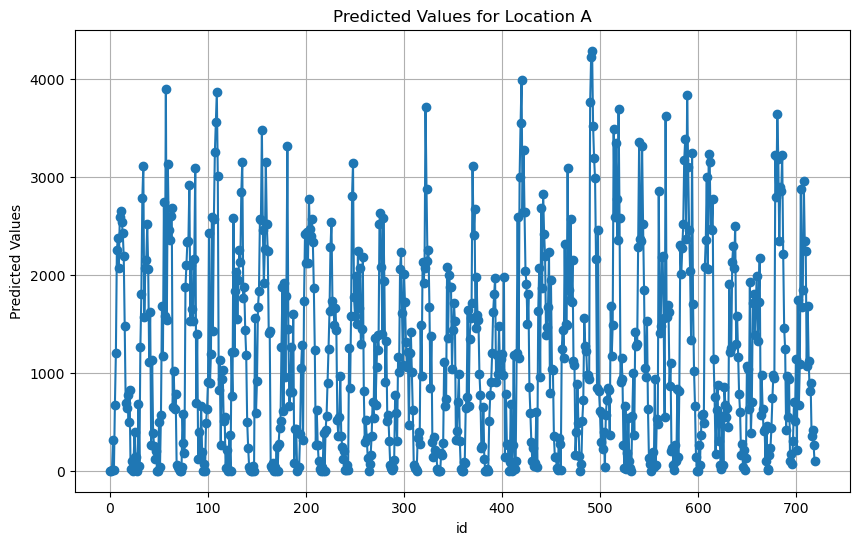

In [77]:
import matplotlib.pyplot as plt

# Assuming you have the 'submission_A' DataFrame as described
x = submission_A['id']
y = submission_A['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location A')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

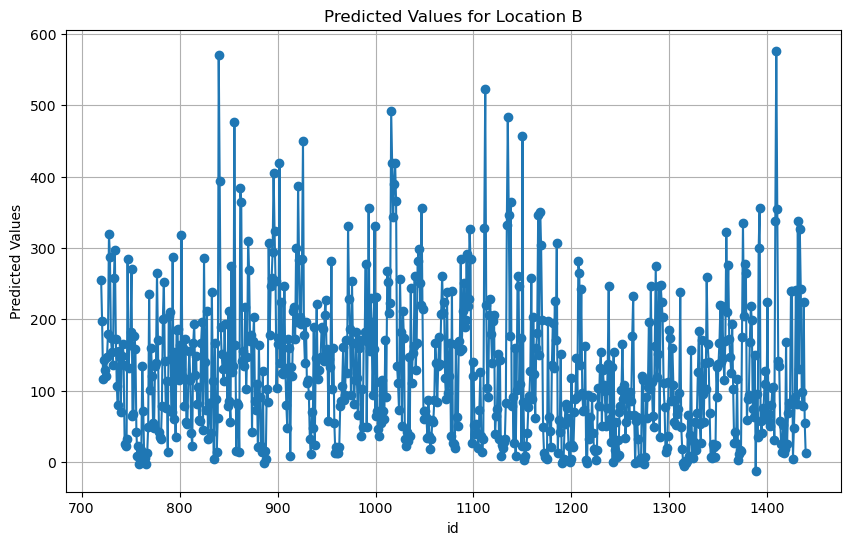

In [78]:
x = submission_B['id']
y = submission_B['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location B')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

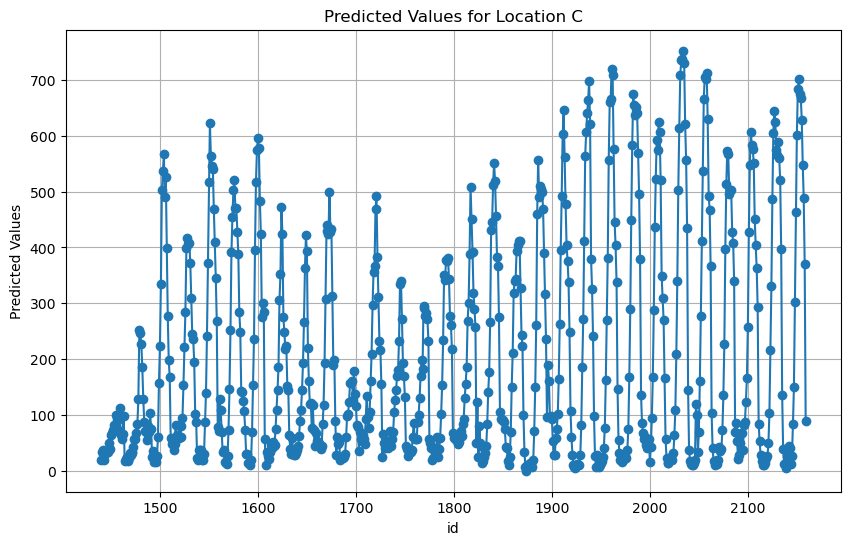

In [79]:
x = submission_C['id']
y = submission_C['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location C')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()